SQL Saturday Phoenix Natural Language Processing (NLP) Demo   
Author: Yueying Li    
Date: 2018-03-17

In [250]:
import logging, warnings
import os
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.models.ldaseqmodel import LdaSeqModel
import numpy as np
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation,strip_multiple_whitespaces,strip_numeric,remove_stopwords,strip_short,stem_text
from collections import Counter
from datetime import datetime
from gensim.models.ldamulticore import LdaMulticore
warnings.filterwarnings('ignore')
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import re
import wordcloud
from gensim.models.coherencemodel import CoherenceModel
from nltk import ngrams
from nltk.stem.snowball import SnowballStemmer

In [251]:
print('Loading data..')

df = pd.read_csv("C:/Users/ying.li/Desktop/tagline.csv", encoding="latin-1")
print('Done.',df.shape[0],'taglines were loaded')
print(df[0:5])
df['tagline'][593]

Loading data..
Done. 37517 taglines were loaded
   year                                            tagline
0  2013    Pretty on the outside, ugly-crying on the in...
1  2004    Her family thinks she won the lottery...What...
2  2013    Jash gave a comedian five thousand dollars t...
3  2006                 Take a picture, it'll last longer.
4  2004             The greatest sport stories never told.


'  A deadly homecoming! Back with guns blazing! Gotta Kill em all!\r\r# "Burey Bhi Hum Bhale Bhi Hum" (2009)\r\tFamily Drama with Comedy\r\r# "Buried Alive" (2007)\r\tSave Your Breath\r\r# "Buried Secrets" (2005)\r\tThe search of history through skeletal remains\r\r# "Burn Notice" (2007)\r\tSpies don t get fired, they get burned. Sun. Surf. Espionage. Burned man. Smoking woman. Trouble in paradise.'

In [252]:
taglines = df['tagline']

# text pre-processing using gensim
CUSTOM_FILTERS = [lambda x: x.lower()
                  , strip_punctuation
                  # optional - might want to keep numbers sometimes
                  , strip_numeric 
                  , remove_stopwords
                  , strip_multiple_whitespaces
                  #removving word of length 1 or 2
                  , strip_short] 

def custom_preprocess_string(x):
    return preprocess_string(x,CUSTOM_FILTERS)

docs=list(map(custom_preprocess_string, taglines))
# check the first processed doc
docs = np.array(docs)
print(len(docs),'taglines were pre-processed')
docs[593]

37517 taglines were pre-processed


['deadly',
 'homecoming',
 'guns',
 'blazing',
 'gotta',
 'kill',
 'burey',
 'bhi',
 'hum',
 'bhale',
 'bhi',
 'hum',
 'family',
 'drama',
 'comedy',
 'buried',
 'alive',
 'save',
 'breath',
 'buried',
 'secrets',
 'search',
 'history',
 'skeletal',
 'remains',
 'burn',
 'notice',
 'spies',
 'fired',
 'burned',
 'sun',
 'surf',
 'espionage',
 'burned',
 'man',
 'smoking',
 'woman',
 'trouble',
 'paradise']

In [258]:
# customized my own stop word list
mystop = {'gotta','burey','bhi','hum','save','bhale','sometimes','greatest','time','vast','get','got','real','better','like','begins','wants'
          ,'way','film','lost','new','meets','hard','second','want','original','poster','story','cap','thing','day','come','people','know','movie'
          ,'little','good','year','caps','ad','all','big','print','great','best','true','screen','need','picture','stop','run','eyes','years'
          ,'look','told','comes','coming','happens','high','won','isn','red','left','past','change','far','stop','inside','meet','inside','seen','away'
         ,'things','face','goes','let','think','going','man','woman','makes','season','live','gets'}

docs2 = []
for doc in docs:
    doc = [i for i in doc if i not in mystop]
    docs2.append(doc)

docs = docs2
print(docs[593])

['deadly', 'homecoming', 'guns', 'blazing', 'kill', 'family', 'drama', 'comedy', 'buried', 'alive', 'breath', 'buried', 'secrets', 'search', 'history', 'skeletal', 'remains', 'burn', 'notice', 'spies', 'fired', 'burned', 'sun', 'surf', 'espionage', 'burned', 'smoking', 'trouble', 'paradise']


In [253]:
df['docs'] = docs
df['len']=list(map(len,df['docs']))
real_df=df[df['len']>0]
real_docs = real_df['docs']
print(len(real_docs),'taglines were left not empty')
real_df[0:5]

37243 taglines were left not empty


,year,tagline,docs,len
0,2013,"Pretty on the outside, ugly-crying on the in...","[pretty, outside, ugly, crying, inside]",5
1,2004,Her family thinks she won the lottery...What...,"[family, thinks, won, lottery, lie]",5
2,2013,Jash gave a comedian five thousand dollars t...,"[jash, gave, comedian, thousand, dollars, dire...",8
3,2006,"Take a picture, it'll last longer.","[picture, longer]",2
4,2004,The greatest sport stories never told.,"[greatest, sport, stories, told]",4


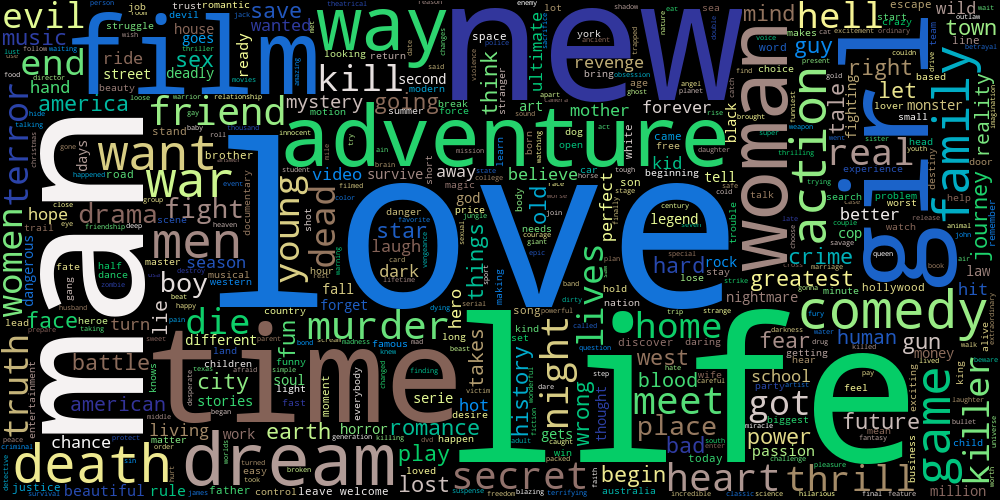

In [259]:
stopwords = wordcloud.STOPWORDS
stopwords.update(())

word_string = [' '.join(word) for word in real_docs]
word_string = ' '.join(word_string)
# Generate a word cloud image
cloud = wordcloud.WordCloud(height=500
                                , width=1000
                                , max_words=500
                                , colormap="terrain"
                                , collocations = None).generate(word_string)

# Display the generated image:

cloud.to_image()

In [255]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(real_docs)
print('There are total',len(dictionary),'words after pre-processing')
# Filter out words that occur less than 2 documents, or more than 99% of all the documents.
dictionary.filter_extremes(no_below=2, no_above=0.99) 
print('There are total',len(dictionary),'words after filtering')
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(doc) for doc in real_docs]

There are total 27018 words after pre-processing
There are total 12742 words after filtering


In [260]:
# Run data through LDA
t1=datetime.now()

lda = LdaMulticore(corpus
                   , id2word=dictionary
                   , workers=3
                   , iterations=100
                   , num_topics=10
                   , random_state=np.random.RandomState(seed=1254)
                   , chunksize = 100
                   , passes=1)

print('Run time for the LDA model with', len(real_docs) ,'movie taglines:', datetime.now()-t1 )

Run time for the LDA model with 37243 movie taglines: 0:00:10.601993


In [261]:
# print topics from the lda model
data = lda.print_topics(-1,num_words=10)

#Show Topics
d = {}
for i, y in data:
    d['Topic {}'.format(i)] = re.findall('"(.*?)"',y)
    
df1 = pd.DataFrame(d)
print(df1)

   Topic 0 Topic 1 Topic 2 Topic 3 Topic 4   Topic 5   Topic 6    Topic 7  \
0     girl   girls     new    time    film    terror  original        war   
1      man  screen     way    evil    know      kill    poster      world   
2    woman     bad   movie    like    dead       big      caps       west   
3      sex   music    past     old    come      town     print  adventure   
4   little   fight     got    good    live      fear      game        end   
5     meet    land  future    seen     die     right      love   greatest   
6  reality  living   dream     hot   going    dreams     truth        men   
7    lives   young     day   house    best  ultimate   romance        far   
8  revenge   years    city  legend   wrong      face     great       love   
9      isn   world    save    gets    time     women       boy     change   

  Topic 8  Topic 9  
0   story  picture  
1    life  thrills  
2    love  mystery  
3   death   action  
4   night   thrill  
5     man      man  
6    

In [262]:
#visualizing topics
import pyLDAvis.gensim
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      12.872821        1       1 -0.131752 -0.194422
8      11.609964        1       2  0.019791  0.008458
7      11.344543        1       3 -0.081710 -0.014141
2       9.479174        1       4  0.092735 -0.243217
3       9.350805        1       5  0.090807  0.162184
4       9.331387        1       6  0.188673  0.076060
9       9.232997        1       7 -0.292908  0.073172
0       9.115438        1       8 -0.068853  0.096554
1       9.035330        1       9  0.061101  0.158947
5       8.627548        1      10  0.122115 -0.123594, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
1369  Default  2358.000000     original  2358.000000  30.0000  30.0000
113   Default  1829.000000        story  1829.000000  29.0000  29.0000
123   Default  2042.000000         life  2042.000000  28.0000  28.0000
4783  Default  1323.000000       poster  1323.000000  27.0000  27.0000
5899  Default  1184.000000         caps  1184.000000  26.0000  26.0000
53    Default  1392.000000          new  1392.000000  25.0000  25.0000
288   Default   841.000000         film   841.000000  24.0000  24.0000
24    Default  2526.000000         love  2526.000000  23.0000  23.0000
813   Default   759.000000          way   759.000000  22.0000  22.0000
207   Default   568.000000         know   568.000000  21.0000  21.0000
122   Default   573.000000          war   573.000000  20.0000  20.0000
5905  Default   615.000000        print   615.000000  19.0000  19.0000
233   Default   513.000000       terror   513.000000  18.0000  18.0000
100   Default   492.000000        movie   492.000000  17.0000  17.0000
195   Default   492.000000         dead   492.000000  16.0000  16.0000
476   Default   644.000000         girl   644.000000  15.0000  15.0000
949   Default   648.000000        death   648.000000  14.0000  14.0000
99    Default  1176.000000         time  1176.000000  13.0000  13.0000
68    Default   455.000000         evil   455.000000  12.0000  12.0000
18    Default   440.000000      picture   440.000000  11.0000  11.0000
304   Default   476.000000        night   476.000000  10.0000  10.0000
683   Default   435.000000         kill   435.000000   9.0000   9.0000
959   Default   428.000000         past   428.000000   8.0000   8.0000
130   Default   412.000000        girls   412.000000   7.0000   7.0000
939   Default   527.000000         come   527.000000   6.0000   6.0000
104   Default   409.000000          got   409.000000   5.0000   5.0000
465   Default   917.000000        woman   917.000000   4.0000   4.0000
420   Default   524.000000          big   524.000000   3.0000   3.0000
537   Default   715.000000         like   715.000000   2.0000   2.0000
388   Default   430.000000         west   430.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
846   Topic10    74.907356       animal    75.711784   2.4395  -5.5860
1305  Topic10    73.847450      morning    74.651985   2.4394  -5.6002
1013  Topic10    73.758324          eat    74.562706   2.4394  -5.6014
721   Topic10    72.282707         saga    73.087128   2.4391  -5.6216
4097  Topic10    71.026505        kills    71.835609   2.4389  -5.6392
1102  Topic10   181.365158      passion   183.471954   2.4387  -4.7017
494   Topic10    68.459740       course    69.274612   2.4384  -5.6760
2644  Topic10    66.647697      tragedy    67.452110   2.4382  -5.7028
1420  Topic10    66.455780      tonight    67.260223   2.4382  -5.7057
286   Topic10    67.657173  underground    68.482368   2.4381  -5.6878
1422  Topic10    64.585472        crack    65.390160   2.4378  -5.7342
300   Topic10   311.051575       dreams   314.983795   2.4376  -4.1623
233   Topic10   500.563232       terror   513.266602   2.4251  -3.6865
722   Topic10   119.694191     struggle   1

The coherent metric (u_mass) with 5 number of topics: -5.977389027797793
The coherent metric (u_mass) with 6 number of topics: -6.344165975550035
The coherent metric (u_mass) with 7 number of topics: -7.41542655927583
The coherent metric (u_mass) with 8 number of topics: -7.186028030602569
The coherent metric (u_mass) with 9 number of topics: -7.404294869473039
The coherent metric (u_mass) with 10 number of topics: -8.095383018618913
The coherent metric (u_mass) with 11 number of topics: -8.077531218272705
The coherent metric (u_mass) with 12 number of topics: -8.653923864343861
The coherent metric (u_mass) with 13 number of topics: -8.850788352919066
Run time for the LDA model: 2:19:53.866554


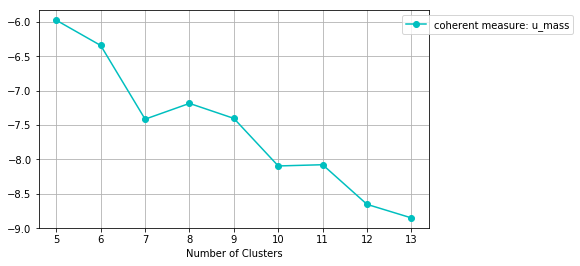

In [64]:
UMs=[]
topic_vals = [5,6,7,8,9,10,11,12,13]
for x in topic_vals:
    lda = LdaMulticore(corpus, id2word=dictionary, workers=3
                                                  ,iterations=200
                                                  ,num_topics=x
                                                  ,random_state=np.random.RandomState(seed=1254)
                                                  ,chunksize = 100
                                                  ,passes=1)
    # Topic quality evaluation
# Topic coherence No.1, using u_mass
    coherenceUM = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass') # ordered words ~0
# the higher the better
    UM = coherenceUM.get_coherence()
    print('The coherent metric (u_mass) with',x,'number of topics:',UM)
    UMs.append(UM)

t2 = datetime.now()
print('Run time for the LDA model:', t2-t1 )

topic_vals = np.array(topic_vals)

fig1 = plt.figure(figsize=(7,4))
ax1 = fig1.add_subplot(111)
ax1.plot(topic_vals,UMs, label='coherent measure: u_mass', color='c', marker='o')
plt.xticks(topic_vals)
plt.xlabel('Number of Clusters')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')

In [266]:
# stemming 
stemmer = SnowballStemmer('english')
docs2 = []
for doc in real_docs:
    doc = [stemmer.stem(w) for w in doc]
    docs2.append(doc)

print(docs2[0])

['pretti', 'outsid', 'ugli', 'cri', 'insid']


In [267]:
#ngram
def my_ngram(tokenized,n):
    grams = list(ngrams(tokenized,n))
    g=[]
    for gram in grams:
        g.append(' '.join(gram))
    return g

docs3 = []
for doc in docs2:
    bigram = my_ngram(doc,2)
    docs3.append(doc+bigram)

print(docs3[0])

['pretti', 'outsid', 'ugli', 'cri', 'insid', 'pretti outsid', 'outsid ugli', 'ugli cri', 'cri insid']


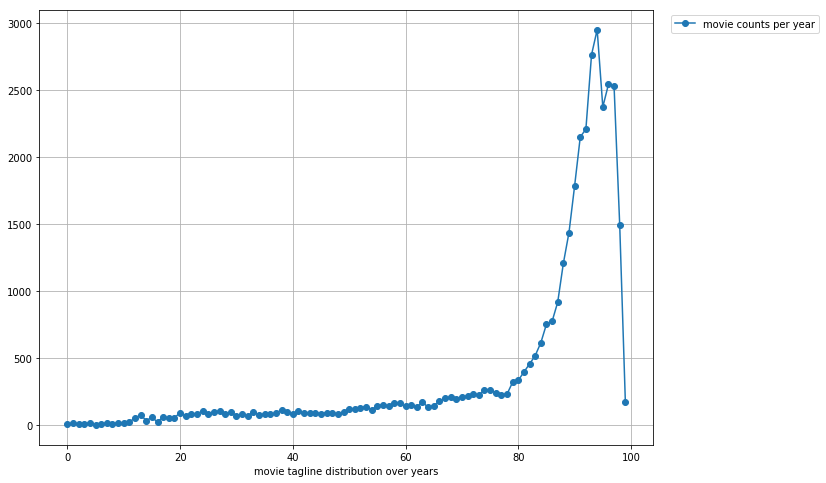

In [263]:
# calculate topic distribution

movie_cnt=list(real_df.groupby('year')['tagline'].agg('count'))

# plot 
fig, ax = plt.subplots(figsize=(11,8))

ax.plot(movie_cnt, label='movie counts per year', marker='o')
plt.xlabel('movie tagline distribution over years')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax.grid('on')
plt.show()

In [264]:
real_df['decade'] = np.where(real_df['year']<1935, 1915
                                 ,np.where(real_df['year']<1955, 1935
                                                   ,np.where(real_df['year']<1975, 1955
                                                                     ,np.where(real_df['year']<1995, 1975,1995))))
real_df=real_df.sort_values('decade')
real_df[0:5]

,year,tagline,docs,len,decade
23359,1934,The Love That Lifted a Man to Paradise.........,"[love, lifted, man, paradise, hurled, earth]",6,1915
16364,1929,Billie DOVE more radiantly beautiful than ev...,"[billie, dove, radiantly, beautiful, private, ...",6,1915
16365,1933,A TRAGIC DRAMA WITH A HAPPY ENDING(original ...,"[tragic, drama, happy, ending, original, poste...",40,1915
16368,1927,It's a Harvest of Hilarity! They All Say It'...,"[harvest, hilarity, colleen, best, saying, lot...",28,1915
10702,1927,You'll graduate with a perpetual smile!,"[graduate, perpetual, smile]",3,1915


In [265]:
real_docs[0]

['pretty', 'outside', 'ugly', 'crying', 'inside']

In [268]:
# get the highest probability associated document topic assignment
topic_number, probas = [], []
for topics in lda[corpus]:
    values=max(topics, key=lambda item: item[1])
    topic_number.append(values[0])
    probas.append(values[1])

df_index = real_df.index.tolist()
df_decade = real_df['decade'].apply(str).tolist()

names = ['index','decade','topics','probability']
one_results = pd.DataFrame(np.column_stack((df_index,df_decade,topic_number,probas)),columns=names)
one_results[0:5]

,index,decade,topics,probability
0,23359,1915,0,0.84999925
1,16364,1915,6,0.3818911
2,16365,1915,8,0.2645071
3,16368,1915,5,0.36709276
4,10702,1915,7,0.8199953


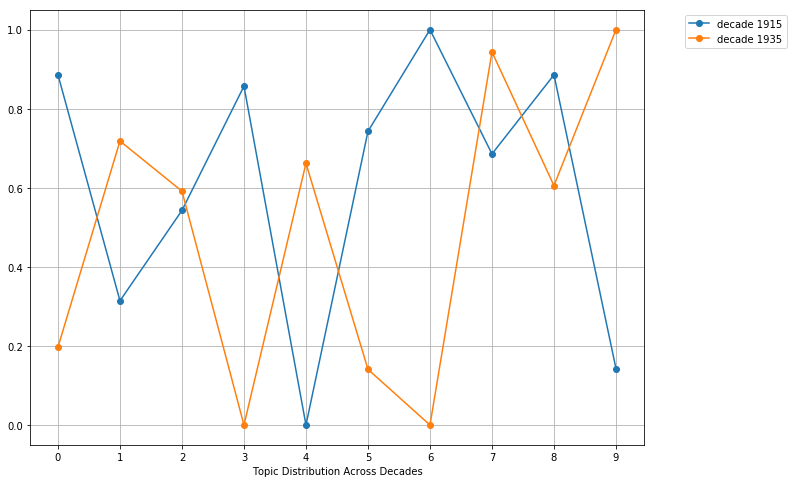

In [271]:
# calculate topic distribution
decades = ['1915','1935','1955','1975','1995']
t_d = pd.DataFrame()
for d in decades:
    t_d[d]=list(one_results[one_results['decade']==d].groupby('topics')['index'].agg('count'))

# min_max normalize
def min_max(x):
    return (x-min(x))/(max(x)-min(x))

t_d_norm = t_d.apply(min_max,0)

import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt

# plot 
topics=t_d.index.tolist()

fig, ax = plt.subplots(figsize=(11,8))


ax.plot(topics,t_d_norm['1915'], label='decade 1915', marker='o')
ax.plot(topics,t_d_norm['1935'], label='decade 1935', marker='o')
#ax.plot(topics,t_d_norm['1955'], label='decade 1955', marker='o')
#ax.plot(topics,t_d_norm['1975'], label='decade 1975', marker='o')
#ax.plot(topics,t_d_norm['1995'], label='decade 1995', marker='o')
plt.xticks(topics)
plt.xlabel('Topic Distribution Across Decades')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax.grid('on')
plt.show()

In [244]:
time_slicer = list(Counter(real_df['decade']).values())    
time_slicer

[601, 1792, 2315, 4098, 27988]

In [247]:
# Build a DTM model
t1=datetime.now()
print(t1)

ldaseq = LdaSeqModel(corpus=corpus, time_slice= time_slicer,id2word=dictionary
                     , num_topics=10
                     , chain_variance=0.05
                     , random_state=np.random.RandomState(seed=1254))
print('Run time for the DTM model with', len(real_docs) ,'movie taglines:', datetime.now()-t1 )

2018-03-17 02:01:58.033627
Run time for the DTM model with 36794 movie taglines: 1:44:41.214309


In [272]:
ldaseq.print_topic(topic=1,time=0,top_terms=10)

[('kill', 0.01177676676713109),
 ('justice', 0.011540353817602522),
 ('tell', 0.00839149074828306),
 ('sin', 0.007414046543903171),
 ('dark', 0.006594190712170893),
 ('australia', 0.0063907598227611155),
 ('video', 0.006279879179391153),
 ('och', 0.006260885830501155),
 ('body', 0.006172970256239026),
 ('play', 0.006032426225481541)]

In [276]:
ldaseq.print_topic(topic=1,time=4,top_terms=10)

[('friends', 0.021583589230434408),
 ('kill', 0.017951180631360968),
 ('believe', 0.015895161989719585),
 ('school', 0.01504742576548611),
 ('chance', 0.013696172976003377),
 ('series', 0.011705308703989684),
 ('justice', 0.010753206874921435),
 ('video', 0.010025213870746225),
 ('dark', 0.009991509801005471),
 ('thought', 0.009588354066715413)]